Random_erase Data Augmentation.

+ https://github.com/zhunzhong07/Random-Erasing


##**Import all neceassary packages**

In [8]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import random
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import datasets, transforms

from tqdm.notebook import tqdm as tqdm
import math
import random

##**Model - Define ResNet Model**

In [2]:
'''ResNet18/34/50/101/152 in Pytorch.'''

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

def test_resnet():
    net = ResNet50()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

# test_resnet()

##**Utils**

In [3]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

##**Parameter Settings**

In [4]:
dataset = 'cifar100' # cifar10 or cifar100
model = 'resnet34' # resnet18, resnet50, resnet101
batch_size = 128  # Input batch size for training (default: 128)
epochs = 150 # Number of epochs to train (default: 200)
learning_rate = 0.1 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
# cutout = True # Apply Cutout?
# n_holes = 1 # Number of holes to cut out from image
# length = 16 # Length of the holes
seed = 0 # Random seed (default: 0)
print_freq = 30
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

np.random.seed(0)
random.seed(0)
# Random Erasing
p=0
sh=0.4
r1=0.3



torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

test_id = dataset + '_' + model

##**Load and preprocess data**

In [5]:
class Randomchanging(object):
    '''
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al. 
    -------------------------------------------------------------------------------------
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3):
        self.probability = probability
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                change_x1 = random.randint(0, img.size()[1] - h) # 새로운 위치 정의
                change_y1 = random.randint(0, img.size()[2] - w) # 새로운 위치 정의
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = img[0, change_x1:change_x1+h, change_y1:change_y1+w] # 새로운 위치의 값으로 변경
                    img[1, x1:x1+h, y1:y1+w] = img[1,change_x1:change_x1+h, change_y1:change_y1+w] # 새로운 위치의 값으로 변경
                    img[2, x1:x1+h, y1:y1+w] = img[2, change_x1:change_x1+h, change_y1:change_y1+w] # 새로운 위치의 값으로 변경
                else:
                    img[0, x1:x1+h, y1:y1+w] = img[0, change_x1:change_x1+h, change_y1:change_y1+w] # 새로운 위치의 값으로 변경
                return img

        return img

In [6]:
# Image Preprocessing
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
if data_augmentation:
    train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
train_transform.transforms.append(Randomchanging(probability = 0.2, sh = 0.2, r1 = 0.3 ))

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])


num_classes = 100
train_dataset = datasets.CIFAR100(root='data/',
                                    train=True,
                                    transform=train_transform,
                                    download=True)

test_dataset = datasets.CIFAR100(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)


train_loader =torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)



Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


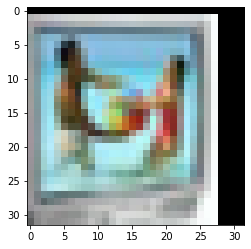

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


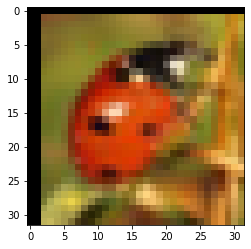

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


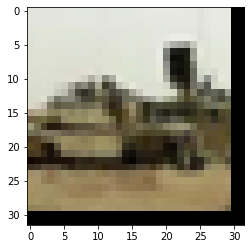

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


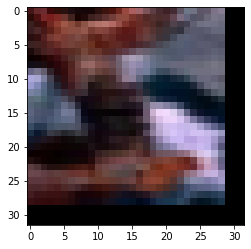

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


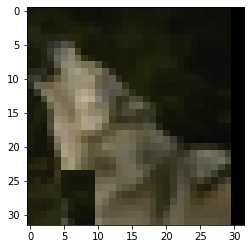

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


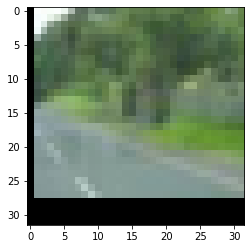

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


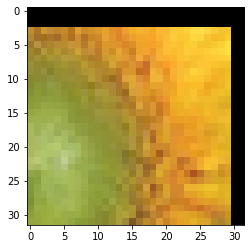

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


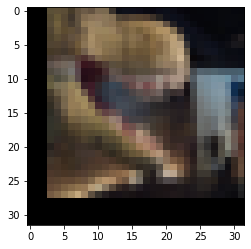

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


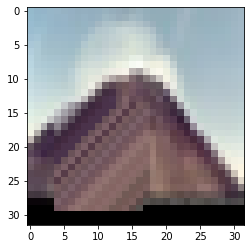

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


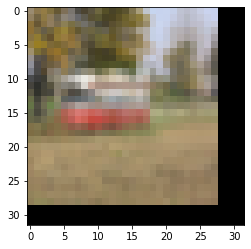

In [ ]:
import matplotlib.pyplot as plt
import math
def custom_imshow(img):
  img = img.numpy()
  img = np.transpose(img, (1, 2, 0))
  mean = np.array([x / 255.0 for x in [125.3, 123.0, 113.9]])
  std = np.array([x / 255.0 for x in [63.0, 62.1, 66.7]])
  img = img*std + mean
  plt.imshow(img)
  plt.show()
  
dataiter = iter(train_loader)
images, labels = dataiter.next()
for i in range(10):
    custom_imshow(images[i])

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path = '/content/drive/MyDrive/4-1 실전기계학습/mid_project'
augmentation_method = '0512_1_random_change_0.2_0.2_0.3_2nd'

In [10]:
def load_model(model, path, method) :

    dir_ckpt = pathlib.Path(path)
    dir_path = dir_ckpt / method / 'checkpoint'
    ckpt_file = dir_path / 'model_best.pth'

    if cuda:
        checkpoint = torch.load(ckpt_file, map_location=lambda storage, loc: storage.cuda(0))
        try:
            model.load_state_dict(checkpoint['model'])
        except:
            model.module.load_state_dict(checkpoint['model'])
    else:
        checkpoint = torch.load(ckpt_file, map_location=lambda storage, loc: storage)
        try:
            model.load_state_dict(checkpoint['model'])
        except:
            # create new OrderedDict that does not contain `module.`
            new_state_dict = OrderedDict()
            for k, v in checkpoint['model'].items():
                if k[:7] == 'module.':
                    name = k[7:] # remove `module.`
                else:
                    name = k[:]
                new_state_dict[name] = v

            model.load_state_dict(new_state_dict)

    return checkpoint

In [11]:
import pathlib

def save_model(state, path, method):
    dir_ckpt = pathlib.Path(path)
    dir_path = dir_ckpt / method / 'checkpoint'
    dir_path.mkdir(parents=True, exist_ok=True)

    model_file = dir_path / 'model_best.pth'
    
    torch.save(state, model_file)

def save_values(epoch, acc1_train, acc5_train, acc1_valid, acc5_valid, path, method):
    dir_ckpt = pathlib.Path(path)
    dir_path = dir_ckpt / method / 'values'
    dir_path.mkdir(parents=True, exist_ok=True)

    acc1_train_file = dir_path / 'acc1_train.txt'
    acc5_train_file = dir_path / 'acc5_train.txt'

    acc1_valid_file = dir_path / 'acc1_valid.txt'
    acc5_valid_file = dir_path / 'acc5_valid.txt'

    with open(acc1_train_file, "a") as f :
        f.write(epoch + ", " + acc1_train + '\n')

    with open(acc5_train_file, "a") as f :
        f.write(epoch + ", " + acc5_train + '\n')

    with open(acc1_valid_file, "a") as f :
        f.write(epoch + ", " + acc1_valid + '\n')

    with open(acc5_valid_file, "a") as f :
        f.write(epoch + ", " + acc5_valid + '\n')

##**Main Training**

In [12]:
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

    return top1.avg, top5.avg

def test(test_loader,epoch, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Test Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg, top5.avg

In [13]:
model = ResNet34(num_classes=num_classes).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)

scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

criterion = torch.nn.CrossEntropyLoss().cuda()
###########################################################
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train_acc1, train_acc5 = train(train_loader, epoch, model, optimizer, criterion)
    test_acc1, test_acc5 = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < test_acc1:
        best_acc = test_acc1
        state = {'epoch': epoch + 1,
                 'model': model.state_dict(),
                 'optimizer': optimizer.state_dict(),
                 'scheduler' : scheduler.state_dict()
                 }
        save_model(state, path, augmentation_method)
    save_values(str(epoch + 1), str(train_acc1), str(train_acc5), str(test_acc1), str(test_acc5), path, augmentation_method)
        
torch.save(model.state_dict(),'model_latest1.pt')
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 0, lr: 0.1 -----
Epoch: [0][  0/391]	Time  1.008 ( 1.008)	Loss 4.7583e+00 (4.7583e+00)	Acc@1   0.78 (  0.78)	Acc@5   6.25 (  6.25)
Epoch: [0][ 30/391]	Time  0.089 ( 0.121)	Loss 4.6713e+00 (5.3942e+00)	Acc@1   0.00 (  1.21)	Acc@5   4.69 (  5.32)
Epoch: [0][ 60/391]	Time  0.093 ( 0.108)	Loss 4.5474e+00 (5.0181e+00)	Acc@1   1.56 (  1.32)	Acc@5   6.25 (  5.55)
Epoch: [0][ 90/391]	Time  0.092 ( 0.103)	Loss 4.5336e+00 (4.8685e+00)	Acc@1   2.34 (  1.66)	Acc@5   9.38 (  6.72)
Epoch: [0][120/391]	Time  0.090 ( 0.101)	Loss 4.3131e+00 (4.7622e+00)	Acc@1   6.25 (  2.01)	Acc@5  16.41 (  8.21)
Epoch: [0][150/391]	Time  0.092 ( 0.099)	Loss 4.2738e+00 (4.6674e+00)	Acc@1   4.69 (  2.57)	Acc@5  15.62 (  9.88)
Epoch: [0][180/391]	Time  0.093 ( 0.098)	Loss 4.2092e+00 (4.5926e+00)	Acc@1   3.12 (  2.87)	Acc@5  14.06 ( 11.11)
Epoch: [0][210/391]	Time  0.092 ( 0.097)	Loss 4.1620e+00 (4.5286e+00)	Acc@1   5.47 (  3.23)	Acc@5  14.06 ( 12.34)
Epoch: [0][240/391]	Time  0.089 ( 0.097)	Loss 4.1529e+00 

# 혹시, 끊어진다면 저장된 checkpoint부터 다시 시작

In [ ]:
model = ResNet34(num_classes=num_classes).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

checkpoint = load_model(model, path, augmentation_method)
start_epoch = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])


criterion = torch.nn.CrossEntropyLoss().cuda()
###########################################################
best_acc = 0
for epoch in range(start_epoch, epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train_acc1, train_acc5 = train(train_loader, epoch, model, optimizer, criterion)
    test_acc1, test_acc5 = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < test_acc1:
        best_acc = test_acc1
        state = {'epoch': epoch + 1,
                 'model': model.state_dict(),
                 'optimizer': optimizer.state_dict(),
                 'scheduler' : scheduler.state_dict()
                }
        save_model(state, path, augmentation_method)
    save_values(str(epoch + 1), str(train_acc1), str(train_acc5), str(test_acc1), str(test_acc5), path, augmentation_method)
        
torch.save(model.state_dict(),'model_latest.pt')
print(f"Best Top-1 Accuracy: {best_acc}")

